# Pulser interface draft

Note that some of the things here we could simply implement them in Pulser directly as they could also be beneficial there. One goal of QoolQit should be to limit and control the information from Pulser that the user interacts with. This can be as simple as redefining the display functions for certain objects, and providing convenience methods for accessing the most relevant information.

## Device

Currently a minimal wrapper on the pulser Device serves to hide most of the hardware specific information provided there. From all the fields in the Pulser device, we should select which ones we want QoolQit users to interact with. 

Currently all the device information is no longer printed, and the `max_atom_num` has been renamed `max_n_qubits`.

In [25]:
from qoolqit import MockDevice, AnalogDevice

MockDevice

MockDevice

In [26]:
print(MockDevice.max_n_qubits)

None


In [27]:
print(AnalogDevice.max_n_qubits)

80


## Register
Registers now display only the number of qubits:

In [12]:
from qoolqit import Register

reg = Register.hexagon(1) 

print(reg)

Register(n_qubits = 7)


This info is directly available with a new property:

In [13]:
reg.n_qubits

7

Previous properties such as the qubit dictionary remain available

In [14]:
reg.qubits

{0: array([0., 0.]),
 1: array([-2.        ,  3.46410162]),
 2: array([2.        , 3.46410162]),
 3: array([4., 0.]),
 4: array([ 2.        , -3.46410162]),
 5: array([-2.        , -3.46410162]),
 6: array([-4.,  0.])}

## Waveforms

Not much of a change but I introduced a piecewise linear waveform because I like this interface. It takes N durations and N+1 points corresponding to values at the start and end of each piece.

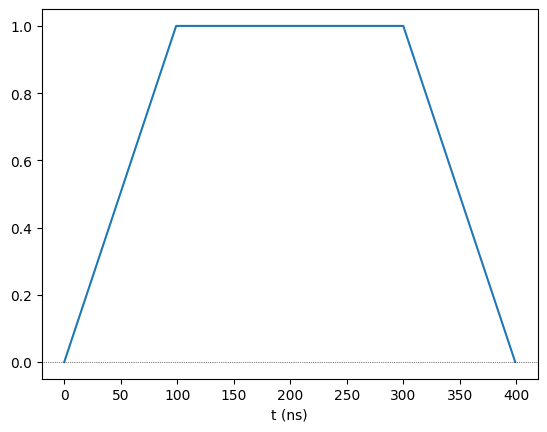

In [37]:
from qoolqit import PWLWaveform

wf = PWLWaveform([100, 200, 100], [0.0, 1.0, 1.0, 0.0])

wf.draw()

Other waveforms remain available with the same interface. I experimented with allowing them to be composed in time via multiplication.

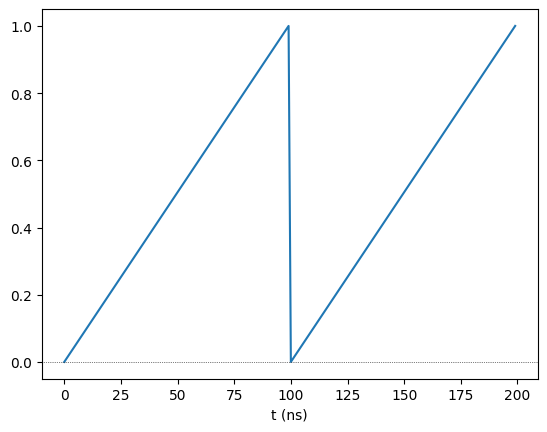

In [38]:
from qoolqit import RampWaveform

wf = RampWaveform(100, 0.0, 1.0)

wf_comp = wf * wf

wf_comp.draw()

## Pulse

All arguments for the pulse are now optional, but at least the amplitude or the detuning need to be passed.

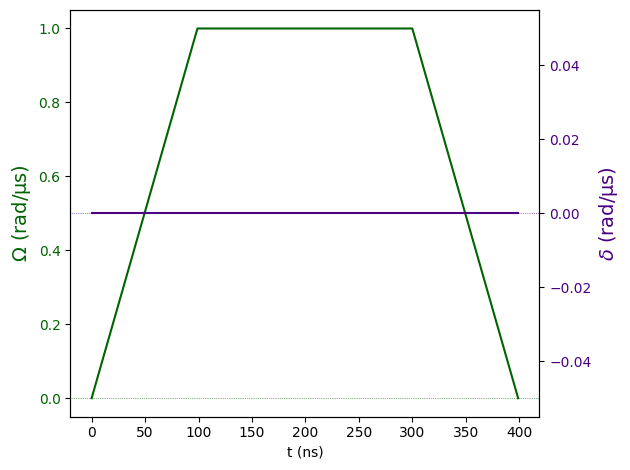

In [39]:
from qoolqit import Pulse, PWLWaveform

wf = PWLWaveform([100, 200, 100], [0.0, 1.0, 1.0, 0.0])

pulse = Pulse(amplitude = wf)

pulse.draw()

In [40]:
try:
    Pulse()
except TypeError as error:
    print(error)

'amplitude' and 'detuning' cannot both be empty.


## Sequence

The Sequence now skips the need for channel declaration, it just sets a rydberg global channel. The default interface for initializing a sequence remains the same.

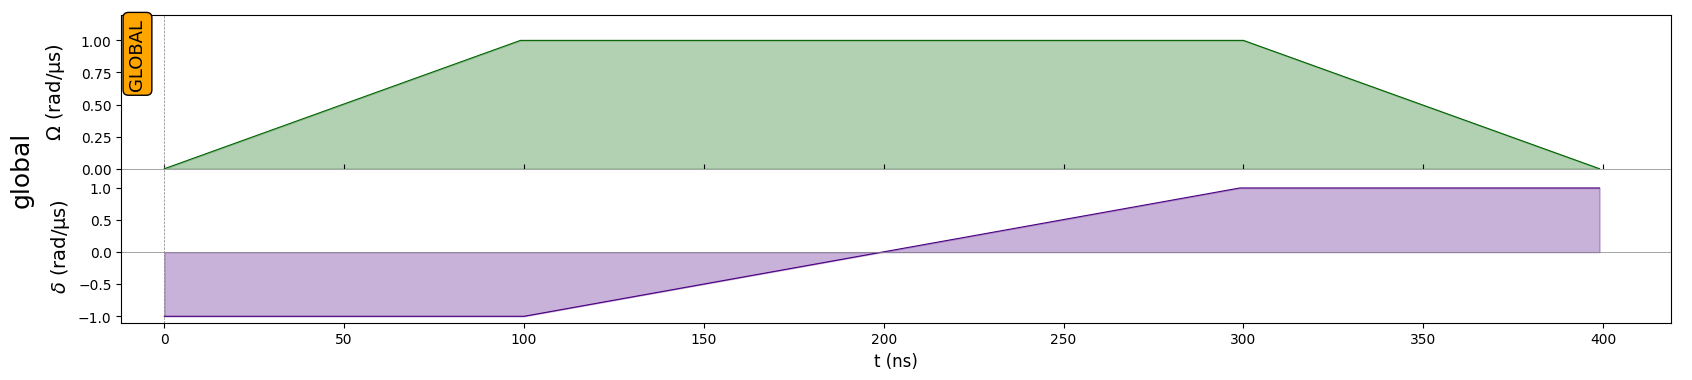

In [42]:
from qoolqit import PWLWaveform, Pulse, MockDevice, Register, Sequence

reg = Register.hexagon(1)

wf_amp = PWLWaveform([100, 200, 100], [0.0, 1.0, 1.0, 0.0])
wf_det = PWLWaveform([100, 200, 100], [-1.0, -1.0, 1.0, 1.0])

pulse = Pulse(wf_amp, wf_det)

seq = Sequence(reg, MockDevice)

seq.add(pulse)

seq.draw()

## Sequence with weights

To include the weighted detuning term, the weights need to be passed at sequence initialization, which under the hood will create the necessary DMM channel.

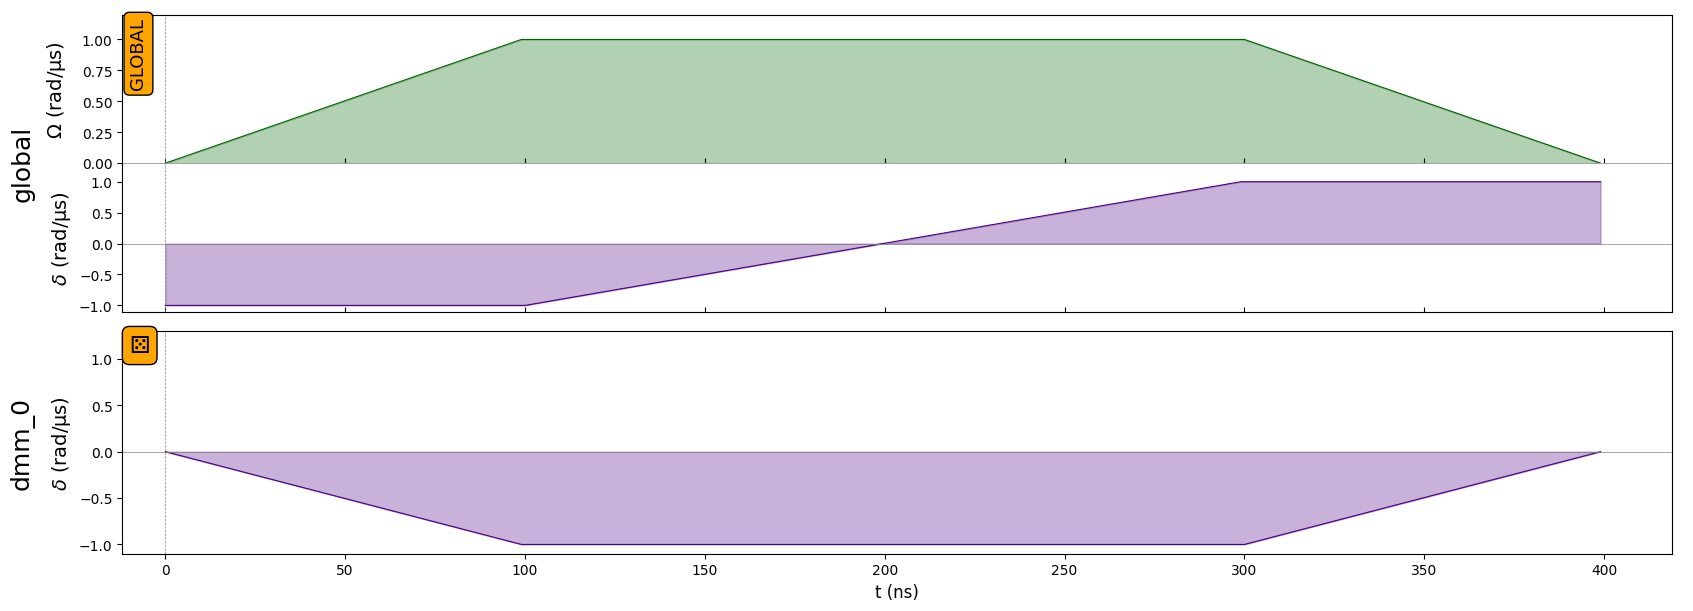

In [45]:
from qoolqit import PWLWaveform, Pulse, MockDevice, Register, Sequence

reg = Register.hexagon(1)

wf_amp = PWLWaveform([100, 200, 100], [0.0, 1.0, 1.0, 0.0])
wf_det = PWLWaveform([100, 200, 100], [-1.0, -1.0, 1.0, 1.0])

pulse = Pulse(wf_amp, wf_det)

weights = {
    0: 1.0,
    1: 0.2,
}

seq = Sequence(reg, MockDevice, weights)

seq.add(pulse)

wf_dmm = PWLWaveform([100, 200, 100], [0.0, -1.0, -1.0, 0.0])

seq.add_weighted_detuning(wf_dmm)

seq.draw()

Note we didn't set weights for all the qubits. Following the Pulser implementation, the remaining ones get set to 0. A new property allows inspecting the sequence weights.

In [47]:
seq.weights

{0: 1.0, 1: 0.2, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0}

# Notes

- This approach tries not to deviate too much from Pulser.
- I have not yet explored the Layout.
- Do we want to allow single-qubit addressability in the interface? I would still skip the whole channel declaration interface, and probably do that through some `qubit_support` or `target` argument for each `Pulse`. Then if a `Pulse` is added to the `Sequence` that targets a specific qubit, the right channel is declared automatically.
- I would like to have the option to use the dimensionless model but I have not yet experimented with how I would implement it. Doing the conversions at the level of the Sequence would be easy, but we probably would need a more complex wrapper on the Waveforms to allow non-integer durations. Also, we would need to rework some of the drawing.